# [COM4513-6513] Assignment 1: Text Classification with Logistic Regression

### Instructor: Nikos Aletras


The goal of this assignment is to develop and test two text classification systems: 

- **Task 1:** sentiment analysis, in particular to predict the sentiment of movie review, i.e. positive or negative (binary classification).
- **Task 2:** topic classification, to predict whether a news article is about International issues, Sports or Business (multiclass classification).


For that purpose, you will implement:

- Text processing methods for extracting Bag-Of-Word features, using (1) unigrams, bigrams and trigrams to obtain vector representations of documents. Two vector weighting schemes should be tested: (1) raw frequencies (**3 marks; 1 for each ngram type**); (2) tf.idf (**1 marks**). 
- Binary Logistic Regression classifiers that will be able to accurately classify movie reviews trained with (1) BOW-count (raw frequencies); and (2) BOW-tfidf (tf.idf weighted) for Task 1. 
- Multiclass Logistic Regression classifiers that will be able to accurately classify news articles trained with (1) BOW-count (raw frequencies); and (2) BOW-tfidf (tf.idf weighted) for Task 2. 
- The Stochastic Gradient Descent (SGD) algorithm to estimate the parameters of your Logistic Regression models. Your SGD algorithm should:
    - Minimise the Binary Cross-entropy loss function for Task 1 (**3 marks**)
    - Minimise the Categorical Cross-entropy loss function for Task 2 (**3 marks**)
    - Use L2 regularisation (both tasks) (**1 mark**)
    - Perform multiple passes (epochs) over the training data (**1 mark**)
    - Randomise the order of training data after each pass (**1 mark**)
    - Stop training if the difference between the current and previous validation loss is smaller than a threshold (**1 mark**)
    - After each epoch print the training and development loss (**1 mark**)
- Discuss how did you choose hyperparameters (e.g. learning rate and regularisation strength)?  (**2 marks; 0.5 for each model in each task**).
- After training the LR models, plot the learning process (i.e. training and validation loss in each epoch) using a line plot (**1 mark; 0.5 for both BOW-count and BOW-tfidf LR models in each task**) and discuss if your model overfits/underfits/is about right.
- Model interpretability by showing the most important features for each class (i.e. most positive/negative weights). Give the top 10 for each class and comment on whether they make sense (if they don't you might have a bug!).  If we were to apply the classifier we've learned into a different domain such laptop reviews or restaurant reviews, do you think these features would generalise well? Can you propose what features the classifier could pick up as important in the new domain? (**2 marks; 0.5 for BOW-count and BOW-tfidf LR models respectively in each task**)


### Data - Task 1 

The data you will use for Task 1 are taken from here: [http://www.cs.cornell.edu/people/pabo/movie-review-data/](http://www.cs.cornell.edu/people/pabo/movie-review-data/) and you can find it in the `./data_sentiment` folder in CSV format:

- `data_sentiment/train.csv`: contains 1,400 reviews, 700 positive (label: 1) and 700 negative (label: 0) to be used for training.
- `data_sentiment/dev.csv`: contains 200 reviews, 100 positive and 100 negative to be used for hyperparameter selection and monitoring the training process.
- `data_sentiment/test.csv`: contains 400 reviews, 200 positive and 200 negative to be used for testing.

### Data - Task 2

The data you will use for Task 2 is a subset of the [AG News Corpus](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html) and you can find it in the `./data_topic` folder in CSV format:

- `data_topic/train.csv`: contains 2,400 news articles, 800 for each class to be used for training.
- `data_topic/dev.csv`: contains 150 news articles, 50 for each class to be used for hyperparameter selection and monitoring the training process.
- `data_topic/test.csv`: contains 900 news articles, 300 for each class to be used for testing.


### Submission Instructions

You should submit a Jupyter Notebook file (assignment1.ipynb) and an exported PDF version (you can do it from Jupyter: `File->Download as->PDF via Latex`).

You are advised to follow the code structure given in this notebook by completing all given funtions. You can also write any auxilliary/helper functions (and arguments for the functions) that you might need but note that you can provide a full solution without any such functions. Similarly, you can just use only the packages imported below but you are free to use any functionality from the [Python Standard Library](https://docs.python.org/2/library/index.html), NumPy, SciPy and Pandas. You are not allowed to use any third-party library such as Scikit-learn (apart from metric functions already provided), NLTK, Spacy, Keras etc..

Please make sure to comment your code. You should also mention if you've used Windows (not recommended) to write and test your code. There is no single correct answer on what your accuracy should be, but correct implementations usually achieve F1-scores around 80\% or higher. The quality of the analysis of the results is as important as the accuracy itself. 

This assignment will be marked out of 20. It is worth 20\% of your final grade in the module.

The deadline for this assignment is **23:59 on Fri, 20 Mar 2020** and it needs to be submitted via MOLE. Standard departmental penalties for lateness will be applied. We use a range of strategies to detect [unfair means](https://www.sheffield.ac.uk/ssid/unfair-means/index), including Turnitin which helps detect plagiarism, so make sure you do not plagiarise.



In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random

# fixing random seed for reproducibility
random.seed(123)
np.random.seed(123)


## Load Raw texts and labels into arrays

First, you need to load the training, development and test sets from their corresponding CSV files (tip: you can use Pandas dataframes).

In [2]:
# load the training, development and test sets
train_data = pd.read_csv('data_sentiment/train.csv',header=None, names=['text','label'])
dev_data = pd.read_csv('data_sentiment/dev.csv',header=None, names=['text','label'])
test_data = pd.read_csv('data_sentiment/test.csv',header=None, names=['text','label'])

If you use Pandas you can see a sample of the data.

In [3]:
train_data.head()

,text,label
0,note : some may consider portions of the follo...,1
1,note : some may consider portions of the follo...,1
2,every once in a while you see a film that is s...,1
3,"when i was growing up in 1970s , boys in my sc...",1
4,"the muppet movie is the first , and the best m...",1


In [4]:
type(train_data)

pandas.core.frame.DataFrame

The next step is to put the raw texts into Python lists and their corresponding labels into NumPy arrays:


In [5]:
# put the raw texts into Python lists
train_text = train_data['text'].tolist()
dev_text = dev_data['text'].tolist()
test_text = test_data['text'].tolist()

# put their corresponding labels into NumPy arrays
train_label = np.array(train_data['label'])
dev_label = np.array(dev_data['label'])
test_label = np.array(test_data['label'])


# Bag-of-Words Representation 


To train and test Logisitc Regression models, you first need to obtain vector representations for all documents given a vocabulary of features (unigrams, bigrams, trigrams).


## Text Pre-Processing Pipeline

To obtain a vocabulary of features, you should: 
- tokenise all texts into a list of unigrams (tip: using a regular expression) 
- remove stop words (using the one provided or one of your preference) 
- compute bigrams, trigrams given the remaining unigrams
- remove ngrams appearing in less than K documents
- use the remaining to create a vocabulary of unigrams, bigrams and trigrams (you can keep top N if you encounter memory issues).


In [6]:
stop_words = ['a','in','on','at','and','or', 
              'to', 'the', 'of', 'an', 'by', 
              'as', 'is', 'was', 'were', 'been', 'be', 
              'are','for', 'this', 'that', 'these', 'those', 'you', 'i',
             'it', 'he', 'she', 'we', 'they' 'will', 'have', 'has',
              'do', 'did', 'can', 'could', 'who', 'which', 'what', 
             'his', 'her', 'they', 'them', 'from', 'with', 'its']

### N-gram extraction from a document

You first need to implement the `extract_ngrams` function. It takes as input:
- `x_raw`: a string corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.

and returns:

- `x` : a list of all extracted features.(Remove the same ngram)
- `text_ngrams` : a list of all extracted features.(split for several list by different rows of `x_raw`)

See the examples below to see how this function should work.

In [7]:
def extract_ngrams(x_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', stop_words=[], vocab=set()):    
    # fill in your code...
    x = []
    text_ngrams = []
    for raw in x_raw:
        n_g_list = []
        train_token = re.findall(token_pattern,raw)
        train_stop = []
        for raw_token in train_token:
            if raw_token not in stop_words:
                train_stop.append(raw_token)
    
        for i in range(min(ngram_range),max(ngram_range)+1):
            length = len(train_stop)-i+1
            for j in range(length):
                if i ==1:
                    unigram = train_stop[j]
                    x.append(unigram)
                    n_g_list.append(unigram)
                else:
                    ngrams = tuple(train_stop[j:j+i])
                    x.append(ngrams)
                    n_g_list.append(ngrams)
        text_ngrams.append(n_g_list)
    x = set(x)
    
    return x, text_ngrams




In [14]:
#Get the list of all extracted features for train set
tr_x, tr_text_ngrams = extract_ngrams(x_raw = train_text, stop_words=stop_words)

Note that it is OK to represent n-grams using lists instead of tuples: e.g. `['great', ['great', 'movie']]`

### Create a vocabulary of n-grams

Then the `get_vocab` function will be used to (1) create a vocabulary of ngrams; (2) count the document frequencies of ngrams; (3) their raw frequency. It takes as input:
- `X_raw`: a list of strings each corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.
- `min_df`: keep ngrams with a minimum document frequency.
- `keep_topN`: keep top-N more frequent ngrams.

and returns:

- `vocab`: a set of the n-grams that will be used as features.
- `df`: a Counter (or dict) that contains ngrams as keys and their corresponding document frequency as values.
- `ngram_counts`: counts of each ngram in vocab

Hint: it should make use of the `extract_ngrams` function.

In [9]:
def get_vocab(X_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', min_df=0, keep_topN=5000, stop_words=[]):
    
    x, ngrams_list = extract_ngrams(x_raw=X_raw, stop_words=stop_words)
    df = {}    
                    
    for grams in ngrams_list:
        grams_uni = set(grams)
        for n_gram in grams_uni:
            if n_gram not in df.keys():
                df[n_gram]=1
            else:
                df[n_gram]+=1

    #order by the dict.values              
    df = dict(sorted(df.items(), key=lambda x:x[1], reverse=True))
    #keep top-N more frequent ngrams
    df = {k: df[k] for k in list(df.keys())[:keep_topN]}
 
    vocab= [ i for i in df.keys()]
    ngram_counts= [ i for i in df.values()]
    
    return vocab, df, ngram_counts

Now you should use `get_vocab` to create your vocabulary and get document and raw frequencies of n-grams:

In [10]:
vocab, tr_df, tr_ngram_counts = get_vocab(X_raw=train_text, ngram_range=(1,3), keep_topN=5000, stop_words=stop_words)

In [11]:
tr_df

{'but': 1334,
 'one': 1247,
 'film': 1231,
 'not': 1170,
 'all': 1117,
 'movie': 1095,
 'out': 1080,
 'so': 1047,
 'there': 1046,
 'like': 1043,
 'more': 1040,
 'up': 1020,
 'about': 1010,
 'when': 1008,
 'some': 965,
 'if': 939,
 'just': 925,
 'only': 923,
 'into': 920,
 'than': 912,
 'their': 899,
 'even': 899,
 'time': 874,
 'most': 851,
 'no': 845,
 'good': 825,
 'much': 802,
 'him': 789,
 'would': 776,
 'other': 773,
 'get': 768,
 'story': 767,
 'well': 761,
 'will': 758,
 'also': 755,
 'two': 752,
 'after': 752,
 'first': 747,
 'character': 743,
 'make': 708,
 'way': 707,
 'characters': 698,
 'off': 695,
 'see': 691,
 'very': 690,
 'while': 678,
 'does': 665,
 'any': 664,
 'where': 658,
 'too': 658,
 'little': 652,
 'plot': 645,
 'because': 633,
 'over': 630,
 'director': 624,
 'had': 621,
 'how': 621,
 'then': 613,
 'best': 606,
 'being': 606,
 'people': 605,
 'doesn': 591,
 'really': 587,
 'man': 585,
 'never': 583,
 'life': 582,
 'through': 579,
 'films': 578,
 'here': 575,
 '

Then, you need to create vocabulary id -> word and id -> word dictionaries for reference:

In [12]:
# create word dictionaries 
vocab_dict = {}
for i in range(len(vocab)):
    vocab_dict[i] = vocab[i]

Now you should be able to extract n-grams for each text in the training, development and test sets:

In [15]:
dev_x, dev_text_ngrams = extract_ngrams(x_raw = dev_text, stop_words=stop_words)
test_x, test_text_ngrams = extract_ngrams(x_raw = test_text, stop_words=stop_words)

## Vectorise documents 

Next, write a function `vectoriser` to obtain Bag-of-ngram representations for a list of documents. The function should take as input:
- `X_ngram`: a list of texts (documents), where each text is represented as list of n-grams in the `vocab`
- `vocab`: a set of n-grams to be used for representing the documents

and return:
- `X_vec`: an array with dimensionality Nx|vocab| where N is the number of documents and |vocab| is the size of the vocabulary. Each element of the array should represent the frequency of a given n-gram in a document.


In [16]:
def vectorise(X_ngram, vocab):
    
    X_vec = np.zeros((len(X_ngram),len(vocab)))
    for i, text in enumerate(X_ngram):
        for j, word in enumerate(vocab):
            count = text.count(word)
            X_vec[i][j]=count
                
    
    return X_vec

Finally, use `vectorise` to obtain document vectors for each document in the train, development and test set. You should extract both count and tf.idf vectors respectively:

#### Count vectors

In [17]:
X_tr_count = vectorise(X_ngram=tr_text_ngrams, vocab=vocab)
X_dev_count = vectorise(X_ngram=dev_text_ngrams, vocab=vocab)
X_test_count = vectorise(X_ngram=test_text_ngrams, vocab=vocab)

In [18]:
X_tr_count

array([[ 6.,  8., 20., ...,  0.,  1.,  1.],
       [ 2.,  5.,  6., ...,  0.,  0.,  0.],
       [ 5.,  4.,  8., ...,  0.,  0.,  0.],
       ...,
       [ 3.,  2.,  4., ...,  0.,  0.,  0.],
       [11.,  7., 11., ...,  0.,  0.,  0.],
       [ 2.,  3.,  8., ...,  0.,  0.,  0.]])

In [19]:
X_tr_count.shape

(1400, 5000)

#### TF.IDF vectors

First compute `idfs` an array containing inverted document frequencies (Note: its elements should correspond to your `vocab`)

Then transform your count vectors to tf.idf vectors:

In [20]:
# create idf vocabulary dictiongnary for training data
vocab_idfs_tr={}
for word in vocab:
    doc_count=0
    for text in tr_text_ngrams:
        if word in text:
            doc_count+=1
    vocab_idfs_tr[word]=np.log((len(tr_text_ngrams)/doc_count))

In [21]:
vocab_idfs_tr

{'but': 0.04829028912778086,
 'one': 0.11573156992331361,
 'film': 0.12864538941889642,
 'not': 0.17946848781154814,
 'all': 0.2258257165341493,
 'movie': 0.24571787335274872,
 'out': 0.2595111954850846,
 'so': 0.2905433047328132,
 'there': 0.29149887097848187,
 'like': 0.29437106060257756,
 'more': 0.2972515234679317,
 'up': 0.31666960932503324,
 'about': 0.3265219057680448,
 'when': 0.32850406697203605,
 'some': 0.3720994142643641,
 'if': 0.399412036395087,
 'just': 0.41443377809092485,
 'only': 0.4165982811004978,
 'into': 0.41985384556026406,
 'than': 0.4285875255290187,
 'their': 0.44294448113172963,
 'even': 0.44294448113172963,
 'time': 0.4711471399478145,
 'most': 0.4978153870299759,
 'no': 0.5048908882461761,
 'good': 0.528844129268669,
 'much': 0.5571189077368355,
 'him': 0.5734611947574757,
 'would': 0.5900749954201312,
 'other': 0.593948467015928,
 'get': 0.6004377824556778,
 'story': 0.6017407142360938,
 'well': 0.6095941577416641,
 'will': 0.6135441299609784,
 'also': 0.6

In [22]:
# create idf vocabulary dictiongnary for development data
vocab_idfs_dev={}
for word in vocab:
    doc_count=0
    for text in dev_text_ngrams:
        if word in text:
            doc_count+=1
    vocab_idfs_dev[word]=np.log((len(dev_text_ngrams)+1) / (doc_count+1))

In [23]:
# create idf vocabulary dictiongnary for test data
vocab_idfs_test={}
for word in vocab:
    doc_count=0
    for text in test_text_ngrams:
        if word in text:
            doc_count+=1
    vocab_idfs_test[word]=np.log((len(test_text_ngrams)+1) / (doc_count+1))

In [24]:
# For training set, extract tf.idf vectors
tfidf_mat=[]
for i, word in enumerate(vocab_idfs_tr.keys()):
    value = X_tr_count[:,i]
    tfidf = value * vocab_idfs_tr[word]
    tfidf_mat.append(tfidf)

X_tr_tfidf = np.asarray(tfidf_mat)
X_tr_tfidf = np.transpose(X_tr_tfidf)

In [25]:
# For development set, extract tf.idf vectors
tfidf_mat=[]
for i, word in enumerate(vocab_idfs_dev.keys()):
    value = X_dev_count[:,i]
    tfidf = value * vocab_idfs_dev[word]
    tfidf_mat.append(tfidf)

X_dev_tfidf = np.asarray(tfidf_mat)
X_dev_tfidf = np.transpose(X_dev_tfidf)

In [26]:
# For test set, extract tf.idf vectors
tfidf_mat=[]
for i, word in enumerate(vocab_idfs_test.keys()):
    value = X_test_count[:,i]
    tfidf = value * vocab_idfs_test[word]
    tfidf_mat.append(tfidf)

X_test_tfidf = np.asarray(tfidf_mat)
X_test_tfidf = np.transpose(X_test_tfidf)

In [27]:
X_tr_tfidf.shape

(1400, 5000)

In [28]:
X_tr_tfidf

array([[0.28974173, 0.92585256, 2.57290779, ..., 0.        , 4.41101417,
        4.41101417],
       [0.09658058, 0.57865785, 0.77187234, ..., 0.        , 0.        ,
        0.        ],
       [0.24145145, 0.46292628, 1.02916312, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.14487087, 0.23146314, 0.51458156, ..., 0.        , 0.        ,
        0.        ],
       [0.53119318, 0.81012099, 1.41509928, ..., 0.        , 0.        ,
        0.        ],
       [0.09658058, 0.34719471, 1.02916312, ..., 0.        , 0.        ,
        0.        ]])

# Binary Logistic Regression

After obtaining vector representations of the data, now you are ready to implement Binary Logistic Regression for classifying sentiment.

First, you need to implement the `sigmoid` function. It takes as input:

- `z`: a real number or an array of real numbers 

and returns:

- `sig`: the sigmoid of `z`

In [30]:
def sigmoid(z):
    
    sig = 1. / (1 + np.exp(-z))
    
    return sig




In [31]:
print(sigmoid(0)) 
print(sigmoid(np.array([-5., 1.2])))

0.5
[0.00669285 0.76852478]


Then, implement the `predict_proba` function to obtain prediction probabilities. It takes as input:

- `X`: an array of inputs, i.e. documents represented by bag-of-ngram vectors ($N \times |vocab|$)
- `weights`: a 1-D array of the model's weights $(1, |vocab|)$

and returns:

- `preds_proba`: the prediction probabilities of X given the weights

In [32]:
def predict_proba(X, weights):
    
    dot_p = np.dot(X,weights)
    preds_proba = sigmoid(dot_p)
    
    return preds_proba

Then, implement the `predict_class` function to obtain the most probable class for each vector in an array of input vectors. It takes as input:

- `X`: an array of documents represented by bag-of-ngram vectors ($N \times |vocab|$)
- `weights`: a 1-D array of the model's weights $(1, |vocab|)$

and returns:

- `preds_class`: the predicted class for each x in X given the weights

In [33]:
def predict_class(X, weights):
    
    proba = predict_proba(X = X, weights = weights)
    proba[proba<0.5]=0
    proba[proba>=0.5]=1
    preds_class = proba.astype(np.int64)
       
    return preds_class

To learn the weights from data, we need to minimise the binary cross-entropy loss. Implement `binary_loss` that takes as input:

- `X`: input vectors
- `Y`: labels
- `weights`: model weights
- `alpha`: regularisation strength

and return:

- `l`: the loss score

In [45]:
def binary_loss(X, Y, weights, alpha=0.00001):
    
    
    y_pred = predict_proba(X = X, weights = weights)
    # Clip y_pred between alpha and 1-alpha
    y_pred = np.clip(y_pred, alpha, 1-alpha)
    loss = - Y * np.log(y_pred) - (1 - Y) * np.log(1-y_pred)
    if len(X.shape) > 1:
        L2_regularization = (1/len(X))*(alpha/2)*(np.sum(np.square(weights)))
    else:
        L2_regularization = (alpha/2)*(np.sum(np.square(weights)))
    l = loss + L2_regularization

    return l


Now, you can implement Stochastic Gradient Descent to learn the weights of your sentiment classifier. The `SGD` function takes as input:

- `X_tr`: array of training data (vectors)
- `Y_tr`: labels of `X_tr`
- `X_dev`: array of development (i.e. validation) data (vectors)
- `Y_dev`: labels of `X_dev`
- `lr`: learning rate
- `alpha`: regularisation strength
- `epochs`: number of full passes over the training data
- `tolerance`: stop training if the difference between the current and previous validation loss is smaller than a threshold
- `print_progress`: flag for printing the training progress (train/validation loss)


and returns:

- `weights`: the weights learned
- `training_loss_history`: an array with the average losses of the whole training set after each epoch
- `validation_loss_history`: an array with the average losses of the whole development set after each epoch

In [1]:
def SGD(X_tr, Y_tr, X_dev=[], Y_dev=[], lr=0.1, alpha=0.00001, epochs=100, tolerance=0.0001, print_progress=True):
    
    pre_loss_dev = 10.
    training_loss_history = []
    validation_loss_history = []
    
    weights = np.zeros(X_tr.shape[1])
    
    for i in range(epochs):
        seed_number = random.randint(0,100)
        np.random.seed(seed_number)
        new_X_tr = np.random.permutation(X_tr)
        np.random.seed(seed_number)
        new_Y_tr = np.random.permutation(Y_tr)
        #np.random.shuffle(X_tr)
        tr_loss_list = []
        for j, X_tr_row in enumerate(new_X_tr):
            tr_loss = binary_loss(X = X_tr_row, Y=new_Y_tr[j], weights = weights, alpha=alpha)
            tr_loss_list.append(tr_loss)
            y_pred = predict_proba(X = X_tr_row, weights = weights)
            error = y_pred-new_Y_tr[j]
            weights = weights - lr*error*X_tr_row
        
        aver_tr_loss = np.mean(tr_loss_list)
        training_loss_history.append(aver_tr_loss)
        
        valid_loss = binary_loss(X = X_dev, Y=Y_dev, weights = weights, alpha=alpha)
        valid_loss = sum(valid_loss)/len(valid_loss)
        validation_loss_history.append(valid_loss)
        
        print('Epoch: %d' % i, '| Training loss: %f' % aver_tr_loss, '| Validation loss: %f' % valid_loss)
        
        if (pre_loss_dev-valid_loss)<tolerance:
            break
        pre_loss_dev = valid_loss

    return weights, training_loss_history, validation_loss_history

## Train and Evaluate Logistic Regression with Count vectors

First train the model using SGD:

In [54]:
w_count, loss_tr_count, dev_loss_count = SGD(X_tr = X_tr_count, Y_tr = train_label, 
                                             X_dev=X_dev_count, 
                                             Y_dev=dev_label, 
                                             lr=0.0001,
                                             alpha=0.00001, 
                                             epochs=100)

Epoch: 0 | Training loss: 0.667092 | Validation loss: 0.648186
Epoch: 1 | Training loss: 0.613700 | Validation loss: 0.620111
Epoch: 2 | Training loss: 0.575544 | Validation loss: 0.597200
Epoch: 3 | Training loss: 0.545174 | Validation loss: 0.575119
Epoch: 4 | Training loss: 0.520332 | Validation loss: 0.562586
Epoch: 5 | Training loss: 0.499659 | Validation loss: 0.548996
Epoch: 6 | Training loss: 0.481558 | Validation loss: 0.537920
Epoch: 7 | Training loss: 0.465447 | Validation loss: 0.529423
Epoch: 8 | Training loss: 0.451267 | Validation loss: 0.520813
Epoch: 9 | Training loss: 0.438494 | Validation loss: 0.513920
Epoch: 10 | Training loss: 0.426563 | Validation loss: 0.505638
Epoch: 11 | Training loss: 0.415861 | Validation loss: 0.501830
Epoch: 12 | Training loss: 0.406396 | Validation loss: 0.494390
Epoch: 13 | Training loss: 0.397211 | Validation loss: 0.489219
Epoch: 14 | Training loss: 0.388476 | Validation loss: 0.483934
Epoch: 15 | Training loss: 0.380765 | Validation l

Now plot the training and validation history per epoch. Does your model underfit, overfit or is it about right? Explain why.

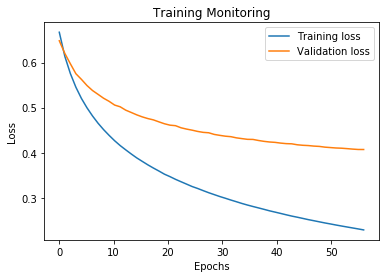

In [55]:
x = np.linspace(0,len(loss_tr_count),len(loss_tr_count))
y1, y2 = loss_tr_count, dev_loss_count
 
plt.plot(x, y1,label='Training loss')
plt.plot(x, y2, label='Validation loss')
 
plt.title('Training Monitoring')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend() 
plt.show()

The model is overfit, because the loss function value of the training data is much larger than that of the validation data.

Compute accuracy, precision, recall and F1-scores:

In [56]:
def accuracy_score(Y_te,preds_te_count):
    
    count = 0
    for i,label in enumerate(Y_te):
        if preds_te_count[i] == label:
            count = count+1
            
    return count/len(Y_te)

In [57]:
def precision_score(Y_te,preds_te_count):
    num = ((Y_te==1)*(preds_te_count==1)).sum()
    deno = (preds_te_count==1).sum()
    return num/deno

def recall_score(Y_te, preds_te_count):
    num = ((Y_te==1)*(preds_te_count==1)).sum()
    deno = (Y_te==1).sum()
    return num/deno

def f1_score(Y_te, preds_te_count):
    num = 2 * precision_score(Y_te, preds_te_count) * recall_score(Y_te, preds_te_count)
    deno = (precision_score(Y_te, preds_te_count) + recall_score(Y_te, preds_te_count))
    return num/deno

In [58]:
# fill in your code...
p_class_count = predict_class(X = X_test_count, weights = w_count)
Y_te = test_label
preds_te_count = p_class_count

print('Accuracy:', accuracy_score(Y_te,preds_te_count))
print('Precision:', precision_score(Y_te,preds_te_count))
print('Recall:', recall_score(Y_te,preds_te_count))
print('F1-Score:', f1_score(Y_te,preds_te_count))

Accuracy: 0.8325
Precision: 0.8275862068965517
Recall: 0.84
F1-Score: 0.8337468982630273


Finally, print the top-10 words for the negative and positive class respectively.

In [59]:
dic_count = {}
for i,weight in enumerate(w_count):
    dic_count[vocab[i]] = weight

# get positive words
dic_count_p = {k:v for k, v in dic_count.items() if v>=0}
#order by weights
dic_count_p= dict(sorted(dic_count_p.items(), key=lambda x:x[1], reverse=True))
# select top 10 words
dic_count_p = {k: dic_count_p[k] for k in list(dic_count_p.keys())[:10]}

# get negative words
dic_count_n = {k:v for k, v in dic_count.items() if v<0}
#order by weights
dic_count_n= dict(sorted(dic_count_n.items(), key=lambda x:x[1], reverse=False))
# select top 10 words
dic_count_n = {k: dic_count_n[k] for k in list(dic_count_n.keys())[:10]}

print("The top 10 positive words are %s respectively."% list(dic_count_p.keys()))
print("The top 10 negative words are %s respectively."% list(dic_count_n.keys()))


The top 10 positive words are ['great', 'well', 'also', 'life', 'seen', 'world', 'many', 'fun', 'movies', 'see'] respectively.
The top 10 negative words are ['bad', 'only', 'worst', 'plot', 'unfortunately', 'script', 'why', 'any', 'boring', 'nothing'] respectively.


If we were to apply the classifier we've learned into a different domain such laptop reviews or restaurant reviews, do you think these features would generalise well? Can you propose what features the classifier could pick up as important in the new domain?

Provide your answer here...

### Discuss how did you choose model hyperparameters (e.g. learning rate and regularisation strength)? What is the relation between training epochs and learning rate? How the regularisation strength affects performance?

## Train and Evaluate Logistic Regression with TF.IDF vectors

Follow the same steps as above (i.e. evaluating count n-gram representations).


In [60]:
w_tfidf, trl, devl = SGD(X_tr = X_tr_tfidf, Y_tr = train_label, 
                         X_dev = X_dev_tfidf, 
                         Y_dev = dev_label, 
                         lr=0.0001, 
                         alpha=0.00001, 
                         epochs=100)

Epoch: 0 | Training loss: 0.630131 | Validation loss: 0.598381
Epoch: 1 | Training loss: 0.491941 | Validation loss: 0.550031
Epoch: 2 | Training loss: 0.414834 | Validation loss: 0.519064
Epoch: 3 | Training loss: 0.362605 | Validation loss: 0.495623
Epoch: 4 | Training loss: 0.324386 | Validation loss: 0.478092
Epoch: 5 | Training loss: 0.294318 | Validation loss: 0.463834
Epoch: 6 | Training loss: 0.270032 | Validation loss: 0.452406
Epoch: 7 | Training loss: 0.249720 | Validation loss: 0.442792
Epoch: 8 | Training loss: 0.232733 | Validation loss: 0.434428
Epoch: 9 | Training loss: 0.217918 | Validation loss: 0.427303
Epoch: 10 | Training loss: 0.204877 | Validation loss: 0.421363
Epoch: 11 | Training loss: 0.193546 | Validation loss: 0.415771
Epoch: 12 | Training loss: 0.183482 | Validation loss: 0.410975
Epoch: 13 | Training loss: 0.174442 | Validation loss: 0.406644
Epoch: 14 | Training loss: 0.166207 | Validation loss: 0.402939
Epoch: 15 | Training loss: 0.158824 | Validation l

Now plot the training and validation history per epoch. Does your model underfit, overfit or is it about right? Explain why.

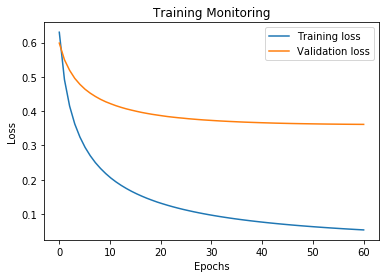

In [61]:
# fill in your code...
x = np.linspace(0,len(trl),len(trl))
y1, y2 = trl, devl
 
plt.plot(x, y1,label='Training loss')
plt.plot(x, y2, label='Validation loss')
 
plt.title('Training Monitoring')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend() 
plt.show()

The model is overfit, because the loss function value of the training data is much larger than that of the validation data.

Compute accuracy, precision, recall and F1-scores:

In [62]:
# fill in your code...
p_class_tfidf = predict_class(X = X_test_tfidf, weights = w_count)
Y_te = test_label
preds_te_tfidf = p_class_tfidf

print('Accuracy:', accuracy_score(Y_te,preds_te_tfidf))
print('Precision:', precision_score(Y_te,preds_te_tfidf))
print('Recall:', recall_score(Y_te,preds_te_tfidf))
print('F1-Score:', f1_score(Y_te,preds_te_tfidf))

Accuracy: 0.835
Precision: 0.7791666666666667
Recall: 0.935
F1-Score: 0.85


Print top-10 most positive and negative words:

In [63]:
dic_tfidf = {}
for i,weight in enumerate(w_tfidf):
    dic_tfidf[vocab[i]] = weight

# get positive words
dic_tfidf_p = {k:v for k, v in dic_tfidf.items() if v>=0}
#order by weights
dic_tfidf_p= dict(sorted(dic_tfidf_p.items(), key=lambda x:x[1], reverse=True))
# select top 10 words
dic_tfidf_p = {k: dic_tfidf_p[k] for k in list(dic_tfidf_p.keys())[:10]}

# get negative words
dic_tfidf_n = {k:v for k, v in dic_tfidf.items() if v<0}
#order by weights
dic_tfidf_n= dict(sorted(dic_tfidf_n.items(), key=lambda x:x[1], reverse=False))
# select top 10 words
dic_tfidf_n = {k: dic_tfidf_n[k] for k in list(dic_tfidf_n.keys())[:10]}

print("The top 10 positive words are %s respectively."% list(dic_tfidf_p.keys()))
print("The top 10 negative words are %s respectively."% list(dic_tfidf_n.keys()))


The top 10 positive words are ['great', 'hilarious', 'fun', 'overall', 'terrific', 'perfectly', 'definitely', 'memorable', 'simple', 'seen'] respectively.
The top 10 negative words are ['bad', 'worst', 'boring', 'supposed', 'unfortunately', 'waste', 'awful', 'poor', 'script', 'nothing'] respectively.


### Discuss how did you choose model hyperparameters (e.g. learning rate and regularisation strength)? What is the relation between training epochs and learning rate? How the regularisation strength affects performance?

Enter your answer here...



## Full Results

Add here your results:

| LR | Precision  | Recall  | F1-Score  |
|:-:|:-:|:-:|:-:|
| BOW-count  | 0.827 | 0.840 | 0.833 |
| BOW-tfidf  | 0.779 | 0.935 | 0.850 |


# Multi-class Logistic Regression 

Now you need to train a Multiclass Logistic Regression (MLR) Classifier by extending the Binary model you developed above. You will use the MLR model to perform topic classification on the AG news dataset consisting of three classes:

- Class 1: World
- Class 2: Sports
- Class 3: Business

You need to follow the same process as in Task 1 for data processing and feature extraction by reusing the functions you wrote.

In [69]:
# load the training, development and test sets
data_tr = pd.read_csv('data_topic/train.csv',header=None, names=['label','text'])
data_dev = pd.read_csv('data_topic/dev.csv',header=None, names=['label','text'])
data_test = pd.read_csv('data_topic/test.csv',header=None, names=['label','text'])

In [70]:
data_tr.head()

,label,text
0,1,Reuters - Venezuelans turned out early\and in ...
1,1,Reuters - South Korean police used water canno...
2,1,Reuters - Thousands of Palestinian\prisoners i...
3,1,AFP - Sporadic gunfire and shelling took place...
4,1,AP - Dozens of Rwandan soldiers flew into Suda...


In [71]:
# put the raw texts into Python lists
train_text = [x.lower() for x in data_tr['text'].tolist()] 
dev_text = [x.lower() for x in data_dev['text'].tolist()] 
test_text = [x.lower() for x in data_test['text'].tolist()]

# put their corresponding labels into NumPy arrays
train_label = np.array(data_tr['label'])
dev_label = np.array(data_dev['label'])
test_label = np.array(data_test['label'])

###  N-gram extraction from the above document

In [72]:
tr_x_mul, tr_text_ngrams_mul = extract_ngrams(x_raw = train_text, stop_words=stop_words)
dev_x_mul, dev_text_ngrams_mul = extract_ngrams(x_raw = dev_text, stop_words=stop_words)
test_x_mul, test_text_ngrams_mul = extract_ngrams(x_raw = test_text, stop_words=stop_words)

Now using `get_vocab` to create your vocabulary and get document and raw frequencies of n-grams:

In [73]:
vocab_mul, tr_df_mul, tr_ngram_counts_mul = get_vocab(X_raw=train_text, ngram_range=(1,3), keep_topN=5000, stop_words=stop_words)

#### Count vectors

In [74]:
X_tr_count_mul = vectorise(X_ngram=tr_text_ngrams_mul, vocab=vocab_mul)
X_dev_count_mul = vectorise(X_ngram=dev_text_ngrams_mul, vocab=vocab_mul)
X_test_count_mul = vectorise(X_ngram=test_text_ngrams_mul, vocab=vocab_mul)

In [75]:
X_tr_count_mul

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       ...,
       [2., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [76]:
X_tr_count_mul.shape

(2400, 5000)

In [77]:
X_dev_count_mul.shape

(150, 5000)

#### TF.IDF vectors

In [78]:
# get idf vocabulary dictiongnary for training data
vocab_idfs_tr_mul={}
for word in vocab_mul:
    doc_count=0
    for text in tr_text_ngrams_mul:
        if word in text:
            doc_count+=1
    vocab_idfs_tr_mul[word]=np.log((len(tr_text_ngrams_mul)/doc_count))

In [79]:
# get idf vocabulary dictiongnary for development data
vocab_idfs_dev_mul={}
for word in vocab_mul:
    doc_count=0
    for text in dev_text_ngrams_mul:
        if word in text:
            doc_count+=1
    vocab_idfs_dev_mul[word]=np.log((len(dev_text_ngrams_mul)+1) / (doc_count+1))

In [80]:
# get idf vocabulary dictiongnary for test data
vocab_idfs_test_mul={}
for word in vocab_mul:
    doc_count=0
    for text in test_text_ngrams_mul:
        if word in text:
            doc_count+=1
    vocab_idfs_test_mul[word]=np.log((len(test_text_ngrams_mul)+1) / (doc_count+1))

In [81]:
# For training set, extract tf.idf vectors
tfidf_mat=[]
for i, word in enumerate(vocab_idfs_tr_mul.keys()):
    value = X_tr_count_mul[:,i]
    tfidf = value * vocab_idfs_tr_mul[word]
    tfidf_mat.append(tfidf)

X_tr_tfidf_mul = np.asarray(tfidf_mat)
X_tr_tfidf_mul = np.transpose(X_tr_tfidf_mul)

In [82]:
# For development set, extract tf.idf vectors
tfidf_mat=[]
for i, word in enumerate(vocab_idfs_dev_mul.keys()):
    value = X_dev_count_mul[:,i]
    tfidf = value * vocab_idfs_dev_mul[word]
    tfidf_mat.append(tfidf)

X_dev_tfidf_mul = np.asarray(tfidf_mat)
X_dev_tfidf_mul = np.transpose(X_dev_tfidf_mul)

In [83]:
# For test set, extract tf.idf vectors
tfidf_mat=[]
for i, word in enumerate(vocab_idfs_test_mul.keys()):
    value = X_test_count_mul[:,i]
    tfidf = value * vocab_idfs_test_mul[word]
    tfidf_mat.append(tfidf)

X_test_tfidf_mul = np.asarray(tfidf_mat)
X_test_tfidf_mul = np.transpose(X_test_tfidf_mul)

Now you need to change `SGD` to support multiclass datasets. First you need to develop a `softmax` function. It takes as input:

- `z`: array of real numbers 

and returns:

- `smax`: the softmax of `z`

In [84]:
def softmax(z):
    x_exp = np.exp(z)
    # If it is a one-dimensional array, then axis = 0, otherwise, axis = 1.
    if len(z.shape) >1:
        x_sum = np.sum(x_exp, axis = 1, keepdims = True)
    else:
        x_sum = np.sum(x_exp, axis = 0)
    smax = x_exp / x_sum    
    return smax

Then modify `predict_proba` and `predict_class` functions for the multiclass case:

In [85]:
def predict_proba(X, weights):
    
    dot_p = np.dot(X,weights.T)
    preds_proba = softmax(dot_p)
    
    return preds_proba

In [86]:
def predict_class(X, weights):
    
    proba = predict_proba(X = X, weights = weights)
    if len(proba.shape) >1:
        label_list = []
        for row in proba:
            row[row == max(row)] = 1
            for i,value in enumerate(row):
                if value == 1:
                    label = i+1
                    label_list.append(label)
                    break;
        preds_class = np.asarray(label_list)
    else:
        proba[proba == max(proba)] = 1
        for i,value in enumerate(proba):
            if value == 1:
                preds_class = i+1
                break;
    
    return preds_class

Toy example and expected functionality of the functions above:

In [87]:
X = np.array([[0.1,0.2],[0.2,0.1],[0.1,-0.2]])
w = np.array([[2,-5],[-5,2]])

In [88]:
predict_proba(X, w)

array([[0.33181223, 0.66818777],
       [0.66818777, 0.33181223],
       [0.89090318, 0.10909682]])

In [89]:
predict_class(X, w)

array([2, 1, 1])

Now you need to compute the categorical cross entropy loss (extending the binary loss to support multiple classes).

In [90]:
def categorical_loss(X, Y, weights, num_classes=3, alpha=0.00001):
    
    y_pred = predict_proba(X = X, weights = weights)
    #Clip y_pred between alpha and 1-alpha
    y_pred = np.clip(y_pred, alpha, 1-alpha)
    if len(X.shape) > 1:
        loss = -np.log(y_pred[range(len(Y)),Y-1])
        L2_regularization = (1/len(X))*(alpha/2)*(np.sum(np.square(weights)))
    else:
        loss = -np.log(y_pred[Y-1])
        L2_regularization = (alpha/2)*(np.sum(np.square(weights)))
    l = loss + L2_regularization
    
    return l
    

In [91]:
def onehot(X,class_nums):
    
    array = np.eye(class_nums+1)[X]
    
    return np.delete(array,0,axis=1)

Finally you need to modify SGD to support the categorical cross entropy loss:

In [103]:
def SGD(X_tr, Y_tr, X_dev=[], Y_dev=[], num_classes=3, lr=0.01, alpha=0.00001, epochs=5, tolerance=0.001, print_progress=True):
    
    pre_loss_dev = 10.
    training_loss_history = []
    validation_loss_history = []
    
    weights = np.zeros((3, len(vocab_mul)))
    Y_tr_onehot = onehot(array = Y_tr,class_num=num_classes)
    
    for i in range(epochs):
        np.random.seed(i)
        new_X_tr = np.random.permutation(X_tr)
        np.random.seed(i)
        new_Y_tr = np.random.permutation(Y_tr)
        np.random.seed(i)
        new_Y_tr_onehot = np.random.permutation(Y_tr_onehot)
        #np.random.shuffle(X_tr)
        tr_loss_list = []
        for j, X_tr_row in enumerate(new_X_tr):
            tr_loss = categorical_loss(X = X_tr_row, Y=new_Y_tr[j], weights = weights, alpha=alpha)
            tr_loss_list.append(tr_loss)
            y_pred = predict_proba(X = X_tr_row, weights = weights)
            error = y_pred - new_Y_tr_onehot[j]
            weights_list = []
            for n in range(num_classes):
                weights_row = weights[n] - lr*X_tr_row*error[n]
                weights_list.append(weights_row)
            weights = np.asarray(weights_list) 
        
        aver_tr_loss = np.mean(tr_loss_list)
        training_loss_history.append(aver_tr_loss)
        
        valid_loss = categorical_loss(X = X_dev, Y=Y_dev, weights = weights, alpha=alpha)
        valid_loss = sum(valid_loss)/len(valid_loss)
        validation_loss_history.append(valid_loss)
        
        print('Epoch: %d' % i, '| Training loss: %f' % aver_tr_loss, '| Validation loss: %f' % valid_loss)
        
        if (pre_loss_dev-valid_loss)<tolerance:
            break
        pre_loss_dev = valid_loss

    return weights, training_loss_history, validation_loss_history

Now you are ready to train and evaluate you MLR following the same steps as in Task 1 for both Count and tfidf features:

In [245]:
w_count, loss_tr_count, dev_loss_count = SGD(X_tr = X_tr_count_mul, Y_tr = train_label, 
                                             X_dev=X_dev_count_mul, 
                                             Y_dev=dev_label,
                                             num_classes=3,
                                             lr=0.001, 
                                             alpha=0.001, 
                                             epochs=200)

Epoch: 0 | Training loss: 0.990924 | Validation loss: 0.977879
Epoch: 1 | Training loss: 0.840919 | Validation loss: 0.895531
Epoch: 2 | Training loss: 0.748140 | Validation loss: 0.833506
Epoch: 3 | Training loss: 0.682860 | Validation loss: 0.784807
Epoch: 4 | Training loss: 0.633647 | Validation loss: 0.745460
Epoch: 5 | Training loss: 0.594811 | Validation loss: 0.712842
Epoch: 6 | Training loss: 0.563061 | Validation loss: 0.685265
Epoch: 7 | Training loss: 0.536481 | Validation loss: 0.661577
Epoch: 8 | Training loss: 0.513770 | Validation loss: 0.640965
Epoch: 9 | Training loss: 0.494028 | Validation loss: 0.622797
Epoch: 10 | Training loss: 0.476689 | Validation loss: 0.606692
Epoch: 11 | Training loss: 0.461263 | Validation loss: 0.592266
Epoch: 12 | Training loss: 0.447425 | Validation loss: 0.579228
Epoch: 13 | Training loss: 0.434920 | Validation loss: 0.567381
Epoch: 14 | Training loss: 0.423531 | Validation loss: 0.556548
Epoch: 15 | Training loss: 0.413119 | Validation l

Plot training and validation process and explain if your model overfit, underfit or is about right:

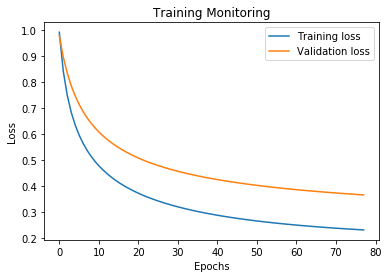

In [248]:
x = np.linspace(0,len(loss_tr_count),len(loss_tr_count))
y1, y2 = loss_tr_count, dev_loss_count
 
plt.plot(x, y1,label='Training loss')
plt.plot(x, y2, label='Validation loss')
 
plt.title('Training Monitoring')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend() 
plt.show()

The model is overfit, because the loss function value of the training data is much larger than that of the validation data.

Compute accuracy, precision, recall and F1-scores:

In [249]:
# fill in your code...
p_class_count = predict_class(X = X_test_count_mul, weights = w_count)
Y_te = test_label
preds_te_count = p_class_count

print('Accuracy:', accuracy_score(Y_te,preds_te_count))
print('Precision:', precision_score(Y_te,preds_te_count))
print('Recall:', recall_score(Y_te,preds_te_count))
print('F1-Score:', f1_score(Y_te,preds_te_count))

Accuracy: 0.8666666666666667
Precision: 0.8245033112582781
Recall: 0.83
F1-Score: 0.8272425249169435


Print the top-10 words for each class respectively.

In [286]:

for i in range(len(w_count)):
    
    dic_count = {}
    for j,weight in enumerate(w_count[i]):
        dic_count[vocab_mul[j]] = weight

    #order by weights
    dic_count_class= dict(sorted(dic_count.items(), key=lambda x:x[1], reverse=True))
    # select top 10 words
    dic_count_class = {k: dic_count_class[k] for k in list(dic_count_class.keys())[:10]}

    print("The top 10 words for class %d are %s respectively."% (i+1, list(dic_count_class.keys())))
    

The top 10 words for class 1 are ['afp', ('athens', 'greece'), 'najaf', 'said', 'president', 'minister', 'monday', 'murder', 'leader', 'troops'] respectively.
The top 10 words for class 2 are ['athens', 'ap', 'team', ('athens', 'reuters'), 'olympic', 'season', 'game', 'coach', 'win', 'olympics'] respectively.
The top 10 words for class 3 are ['company', 'business', 'inc', 'corp', 'oil', 'market', 'billion', 'million', 'based', 'sales'] respectively.


### Discuss how did you choose model hyperparameters (e.g. learning rate and regularisation strength)? What is the relation between training epochs and learning rate? How the regularisation strength affects performance?

Explain here...

### Now evaluate BOW-tfidf...

In [294]:
w_tfidf, loss_tr_tfidf, dev_loss_tfidf = SGD(X_tr = X_tr_tfidf_mul, Y_tr = train_label, 
                                             X_dev=X_dev_tfidf_mul, 
                                             Y_dev=dev_label,
                                             num_classes=3,
                                             lr=0.0001, 
                                             alpha=0.001, 
                                             epochs=100)

Epoch: 0 | Training loss: 0.958516 | Validation loss: 0.956399
Epoch: 1 | Training loss: 0.759553 | Validation loss: 0.866777
Epoch: 2 | Training loss: 0.645353 | Validation loss: 0.802799
Epoch: 3 | Training loss: 0.569673 | Validation loss: 0.754439
Epoch: 4 | Training loss: 0.514993 | Validation loss: 0.716200
Epoch: 5 | Training loss: 0.473164 | Validation loss: 0.685070
Epoch: 6 | Training loss: 0.439735 | Validation loss: 0.659053
Epoch: 7 | Training loss: 0.412274 | Validation loss: 0.636896
Epoch: 8 | Training loss: 0.389099 | Validation loss: 0.617686
Epoch: 9 | Training loss: 0.369242 | Validation loss: 0.600861
Epoch: 10 | Training loss: 0.351926 | Validation loss: 0.585977
Epoch: 11 | Training loss: 0.336668 | Validation loss: 0.572643
Epoch: 12 | Training loss: 0.323066 | Validation loss: 0.560637
Epoch: 13 | Training loss: 0.310853 | Validation loss: 0.549714
Epoch: 14 | Training loss: 0.299777 | Validation loss: 0.539746
Epoch: 15 | Training loss: 0.289692 | Validation l

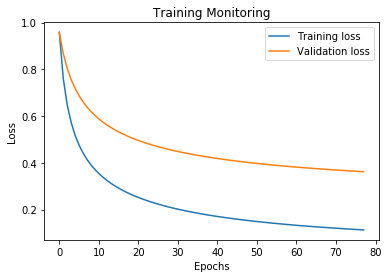

In [296]:
# fill in your code...
x = np.linspace(0,len(loss_tr_tfidf),len(loss_tr_tfidf))
y1, y2 = loss_tr_tfidf, dev_loss_tfidf
 
plt.plot(x, y1,label='Training loss')
plt.plot(x, y2, label='Validation loss')
 
plt.title('Training Monitoring')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend() 
plt.show()

The model is overfit, because the loss function value of the training data is much larger than that of the validation data.

##### Compute accuracy, precision, recall and F1-scores:

In [300]:
p_class_tfidf = predict_class(X = X_test_tfidf_mul, weights = w_count)
Y_te = test_label
preds_te_tfidf = p_class_tfidf

print('Accuracy:', accuracy_score(Y_te,preds_te_tfidf))
print('Precision:', precision_score(Y_te,preds_te_tfidf))
print('Recall:', recall_score(Y_te,preds_te_tfidf))
print('F1-Score:', f1_score(Y_te,preds_te_tfidf))

Accuracy: 0.8777777777777778
Precision: 0.8366013071895425
Recall: 0.8533333333333334
F1-Score: 0.8448844884488449


## Full Results

Add here your results:

| LR | Precision  | Recall  | F1-Score  |
|:-:|:-:|:-:|:-:|
| BOW-count  | 0.824 | 0.830 | 0.827 |
| BOW-tfidf  | 0.836 | 0.853 | 0.844 |
